In [16]:
!pip install awswrangler
import pandas as pd
import awswrangler as wr
import datetime
import os
import matplotlib.pyplot as plt

In this notebook, I use the criteria I defined during data exploration to assign risk scores to each record and eventually train a DeepAR Forecasting model on that data. First, I'll start with assining the scores.

In [28]:
df = wr.athena.read_sql_query(
    sql="SELECT DISTINCT timestamp, machineid, speed_difference, speed, temperature, pressure FROM telemetry_extended_v2",
    database='capstone'
)

In [32]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dropna(inplace=True)

In [71]:
df.sort_values(by='timestamp', inplace=True)
df

,timestamp,machineid,speed_difference,speed,temperature,pressure
11458401,2017-05-15 00:02:00,M_0797,440.05,559.95,22.85,232.93
6363678,2017-05-15 00:02:01,M_0797,169.75,830.25,26.31,507.73
23146136,2017-05-15 00:02:02,M_0797,28.54,971.46,30.43,816.77
6541476,2017-05-15 00:02:03,M_0797,44.94,1044.94,35.14,1050.33
15800303,2017-05-15 00:02:04,M_0797,81.92,1081.92,40.46,1222.83
...,...,...,...,...,...,...
5490284,2017-08-14 22:57:55,M_0449,3.04,3.04,148.73,70.57
1509525,2017-08-14 22:57:56,M_0449,2.48,-2.48,148.60,57.49
25830435,2017-08-14 22:57:57,M_0449,2.80,-2.80,148.71,82.06
541653,2017-08-14 22:57:58,M_0449,0.77,0.77,148.63,89.61


In [75]:
def assign_score(row):
    risk_score = 0
    
    # Check Temperature
    if row['temperature'] > 200:
        risk_score += 3
    elif 175 < row['temperature'] < 200:
        risk_score += 2
    elif 150 < row['temperature'] < 175:
        risk_score += 1
    
    # Check Pressure
    if row['pressure'] < 482:
        risk_score += 1
    elif row['pressure'] > 2114:
        risk_score += 2
    
    # Check Speed Difference
    if row['speed_difference'] > 600:
        risk_score += 4
    elif 500 < row['speed_difference'] < 600:
        risk_score += 3
    elif 400 < row['speed_difference'] < 500:
        risk_score += 2
    elif 200 < row['speed_difference'] < 400:
        risk_score += 1
        
    return risk_score

In [76]:
df['risk_score'] = df.apply(assign_score, axis=1)

In [77]:
df

,timestamp,machineid,speed_difference,speed,temperature,pressure,risk_score
11458401,2017-05-15 00:02:00,M_0797,440.05,559.95,22.85,232.93,3
6363678,2017-05-15 00:02:01,M_0797,169.75,830.25,26.31,507.73,0
23146136,2017-05-15 00:02:02,M_0797,28.54,971.46,30.43,816.77,0
6541476,2017-05-15 00:02:03,M_0797,44.94,1044.94,35.14,1050.33,0
15800303,2017-05-15 00:02:04,M_0797,81.92,1081.92,40.46,1222.83,0
...,...,...,...,...,...,...,...
5490284,2017-08-14 22:57:55,M_0449,3.04,3.04,148.73,70.57,1
1509525,2017-08-14 22:57:56,M_0449,2.48,-2.48,148.60,57.49,1
25830435,2017-08-14 22:57:57,M_0449,2.80,-2.80,148.71,82.06,1
541653,2017-08-14 22:57:58,M_0449,0.77,0.77,148.63,89.61,1


Text(0, 0.5, 'Frequency')

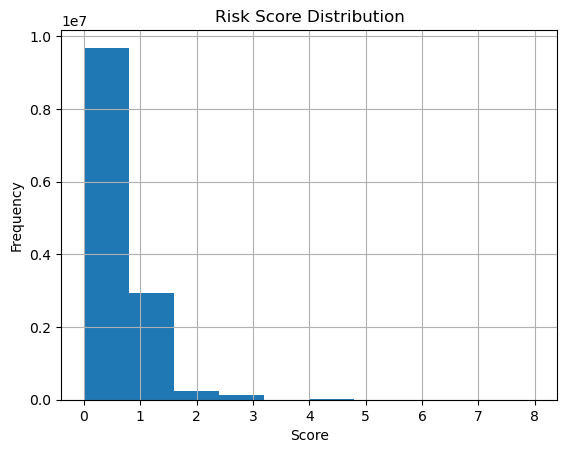

In [88]:
df['risk_score'].hist()
plt.title("Risk Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")

For historic data, I'll look at vehicles that have a risk score of over 5 because that means that there are at least 2 issues with the machine, based on the scoring criteria.

In [85]:
df[df['risk_score'] >= 5]

,timestamp,machineid,speed_difference,speed,temperature,pressure,risk_score
4617128,2017-05-30 12:55:40,M_0108,601.40,601.40,155.46,785.83,5
16021742,2017-05-31 13:41:40,M_0108,601.71,601.71,156.89,766.85,5
2100178,2017-06-01 11:36:40,M_0108,602.87,602.87,158.28,723.77,5
2939326,2017-06-02 06:50:40,M_0108,603.27,603.27,159.28,696.43,5
20743212,2017-06-02 20:33:40,M_0108,605.12,605.12,161.42,671.20,5
...,...,...,...,...,...,...,...
3991791,2017-08-14 15:53:40,M_0788,576.88,576.88,174.85,391.51,5
20454478,2017-08-14 19:02:40,M_0842,667.36,667.36,152.94,987.43,5
3890279,2017-08-14 19:53:40,M_0202,617.71,617.71,154.17,858.74,5
20646056,2017-08-14 21:29:40,M_0911,580.31,580.31,170.12,470.93,5


In [87]:
high_risk = df[df['risk_score'] >= 5]
high_risk['machineid'].unique()

<StringArray>
['M_0108', 'M_0831', 'M_0955', 'M_0643', 'M_0084', 'M_0776', 'M_0029',
 'M_0628', 'M_0136', 'M_0762',
 ...
 'M_0690', 'M_0024', 'M_0647', 'M_0325', 'M_0827', 'M_0770', 'M_0919',
 'M_0435', 'M_0380', 'M_0911']
Length: 284, dtype: string